In [1]:
import torch
import torch.nn as nn
import numpy as np 
import random

import tqdm
import matplotlib.pyplot as plt
import sklearn.cluster

In [55]:
device = torch.device("cuda:5")

H = torch.load("test/original_weights.pt")["H"].to(device).float()
weights = torch.load("test/original_weights.pt")["weights"].to(device).float()  

In [58]:
weights_masked = weights

importances = torch.diag(H).unsqueeze(0).repeat(weights_masked.shape[0],1)
importances = torch.ones_like(importances)
n_bits_inital = 3
centriods = 2**n_bits_inital


kmeans = sklearn.cluster.KMeans(n_clusters=centriods, random_state=0)

quantized = kmeans.fit_predict(weights_masked.cpu().detach().numpy().reshape(-1,1),
                                 sample_weight = importances.cpu().detach().numpy().reshape(-1))
quantized = torch.tensor(quantized).to(device)
values = torch.tensor(kmeans.cluster_centers_).to(device)

/home/lliu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [59]:
w_quantized = values[quantized].reshape(weights_masked.shape)

diff = weights - w_quantized

average_error = torch.sum(torch.abs(diff)**1)/torch.sum(torch.abs(weights)**1)

H_error = torch.einsum('ik,kl,il->', diff, H/H.shape[0], diff)

free, total = torch.cuda.mem_get_info(device)
print(f"free = {free/1024/1024}, total = {total/1024/1024}")

print(f"average error {average_error}, H error {H_error}")

free = 46851.0, total = 48676.75
average error 0.2777968943119049, H error 607.974609375


In [12]:
quantized_counts = torch.unique(quantized, return_counts = True)[1]
entropy = -torch.sum(quantized_counts/quantized_counts.sum()*torch.log2(quantized_counts/quantized_counts.sum()))
print(f"entropy = {entropy}")

entropy = 2.16168475151062


In [13]:
#huffman code the quantized values

class huff_node:
    def __init__(self, value, count):
        self.value = value
        self.count = count
        self.left = None
        self.right = None
        self.code = ""

def huffman_code_recursive(nodes:list[huff_node]):
    if len(nodes) == 1:
        
        return nodes[0]
    nodes = sorted(nodes, key = lambda x: x.count)
    new_node = huff_node(None, nodes[0].count + nodes[1].count)
    new_node.left = nodes[0]
    new_node.right = nodes[1]
    return huffman_code_recursive([new_node] + nodes[2:])

def huffman_code_generate(node:huff_node):
    if node.left is not None:
        node.left.code = node.code + "0"
        huffman_code_generate(node.left)
    if node.right is not None:
        node.right.code = node.code + "1"
        huffman_code_generate(node.right)

def huffman_code(values,counts):
    nodes = [huff_node(value, count) for value, count in zip(values,counts)]
    root = huffman_code_recursive(nodes)
    huffman_code_generate(root)
    return {node.value: node.code for node in nodes}

huffman_codes = huffman_code([v.item() for v in torch.unique(quantized)], quantized_counts)





In [14]:
huffman_codes_ = {values[i]:k for i,k in huffman_codes.items()}
huffman_codes_

{tensor([0.0350], device='cuda:5'): '100',
 tensor([-0.0100], device='cuda:5'): '11',
 tensor([-0.0754], device='cuda:5'): '101011',
 tensor([0.0747], device='cuda:5'): '10100',
 tensor([0.0096], device='cuda:5'): '0',
 tensor([-0.0354], device='cuda:5'): '1011',
 tensor([-0.1502], device='cuda:5'): '1010100',
 tensor([0.1487], device='cuda:5'): '1010101'}

In [15]:
huffman_codes

{0: '100',
 1: '11',
 2: '101011',
 3: '10100',
 4: '0',
 5: '1011',
 6: '1010100',
 7: '1010101'}

In [16]:
n_bits = torch.zeros(values.shape[0], dtype = torch.int32, device = device)

for i in range(values.shape[0]):
    n_bits[i] = len(huffman_codes[i])

total_bits = torch.sum(n_bits*quantized_counts)
print(f"total bits = {total_bits}, average bits = {total_bits/weights.numel()}")

total bits = 37154754, average bits = 2.2145957946777344


In [29]:
n_bits_per_weight = n_bits[quantized].reshape(weights_masked.shape).float()
print(n_bits_per_weight.shape)

torch.Size([4064, 4032])


In [28]:
torch.mean(n_bits_per_weight.float())

tensor(2.2675, device='cuda:5')

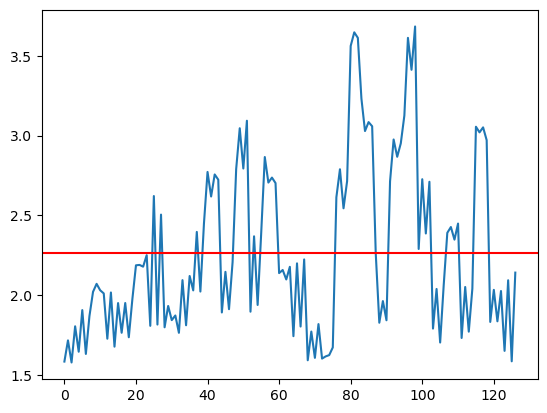

In [35]:
plt.plot(torch.mean(n_bits_per_weight.reshape(n_bits_per_weight.shape[0],-1,d), dim = [1,2]).cpu().numpy())    
plt.axhline(torch.mean(n_bits_per_weight).item(), color = "red")

torch.Size([4032])
tensor([2601, 1447, 2867,  ..., 1677, 2203, 2208], device='cuda:5')
torch.Size([4064, 4032])


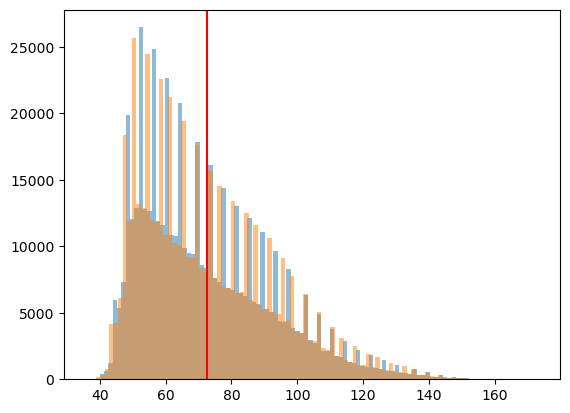

In [54]:
#rearange the rows such that we get close to the minimum

args_sorted = torch.argsort(torch.mean(n_bits_per_weight, dim = 0))
print(args_sorted.shape)
rows_reordered = torch.zeros_like(args_sorted)

rows_reordered[0::2] = args_sorted[:args_sorted.shape[0]//2]
rows_reordered[1::2] = torch.flip(args_sorted[args_sorted.shape[0]//2:], [0])
print(rows_reordered)
n_bits_per_weight_new = n_bits[quantized].reshape(weights_masked.shape).float()[:,rows_reordered]
print(n_bits_per_weight.shape)

plt.hist(torch.sum(n_bits_per_weight.reshape(n_bits_per_weight.shape[0],-1,d), dim = [2]).cpu().numpy().flatten(),
            alpha = 0.5, bins = 100)
plt.hist(torch.sum(n_bits_per_weight_new.reshape(n_bits_per_weight.shape[0],-1,d), dim = [2]).cpu().numpy().flatten(),
            alpha = 0.5, bins = 100)
plt.axvline(torch.mean(torch.sum(n_bits_per_weight.reshape(n_bits_per_weight.shape[0],-1,d), dim = [2])).item(), color = "red")

In [52]:
x = torch.rand((1,n_bits_per_weight_new.shape[1]), device = device)

torch.allclose(x[:] @ n_bits_per_weight_new.T

tensor([[3746.0354, 3250.1279, 3177.0342,  ..., 5088.7451, 4580.6938,
         5156.8823]], device='cuda:5')

In [40]:
block_size = d

quantized_values = values[quantized].reshape(weights_masked.shape)[rows_reordered].reshape(weights_masked.shape[0],-1,block_size)
quantized_n_bits = n_bits_per_weight_new.reshape(quantized_values.shape)



In [37]:
bits_per_block = n_bits[quantized_blocked].sum(-1).sum(-1).float()
n_values_per_block = block_size[0]*block_size[1]

print(f"average bits per block = {torch.mean(bits_per_block).item()}, average bits per value = {torch.mean(bits_per_block).item()/n_values_per_block}\n",
      f"maximum bits per block = {torch.max(bits_per_block).item()}, minimum bits per block = {torch.min(bits_per_block).item()}\n",
        f"maximum bits per value = {torch.max(bits_per_block).item()/n_values_per_block}, minimum bits per value = {torch.min(bits_per_block).item()/n_values_per_block}")


average bits per block = 36.18826675415039, average bits per value = 2.2617666721343994
 maximum bits per block = 89.0, minimum bits per block = 16.0
 maximum bits per value = 5.5625, minimum bits per value = 1.0
